# Projet numérique : lignes de niveau

Le but de ce projet est de coder un programme permettant de construire les lignes de niveau d'une fonction à deux variables donnée.

### Fonction "find_seed"

Premièrement, nous avons dû coder la fonction "find_seed" qui renvoie les coordonnées du point, s'il existe, où la fonction atteint la valeur souhaitée sur l'arête gauche.
Pour cela, nous avons décidé de procéder par dichotomie. 

On teste l'existence du point en regardant si la fonction f(t) = g(0,t) - c change de signe sur le bord gauche du domaine de définition.

In [2]:
#préalablement :

import autograd
from autograd import numpy as np
from matplotlib import pyplot as plt

In [3]:
#code

def find_seed(g, c=0, eps=2**(-26)):
    def f(t):
        return g(0,t)-c
    if f(0)*f(1)>0:
        return None
    else:
        a=0
        b=1
        while np.abs(b-a)>eps:
            m=(a+b)/2
            if f(m)*f(a)>0:
                a=m
            else:
                b=m
        return (a+b)/2

In [9]:
#exemple de résultat du seed

def g(x,y) :
    return x**2 + y**2

a = find_seed(g, 1/2)
b = np.sqrt(2)/2

print(a)
print(b)
print("écart relatif : ",(b-a) / a)
    

0.707106776535511
0.7071067811865476
écart relatif :  6.577559019699244e-09


### Fonction contour

Le but de la fonction simple_contour est de renvoyer les coordonnées d'un fragment de la ligne de niveau discrétisée sous la forme de deux tableaux 1D d'abscisses et d'ordonnées.

Voici notre procédé :
    - on trouve notre point de départ, s'il existe, grâce à la fonction find_seed
    - nous utilisons une propriété du gradient : celui-ci est orthogonal aux lignes de niveau en tout point de la fonction, gradient définit dans grad_f
    - à partir du point trouvé par find_seed, on se déplace d'une distance delta en suivant l'orthogonal du gradient (ortho) 
    - on réitère l'opération à partir du nouveau point trouvé tant qu'on reste dans le plan [0,1],[0,1].


In [16]:
#code
def simple_contour_euler(f, c=0.0, delta=0.01):
    s=find_seed(f,c)
    X=[0]
    Y=[s]
    x0=0
    y0=s
    
    def grad_f(x,y) :
        g = autograd.grad
        return np.r_[g(f,0)(x,y),g(f,1)(x,y)]
    
    while 0<= x0 <=1 and 0 <= y0 <=1:
        
        g=grad_f(float(x0),float(y0))
        x=g[0]
        y=g[1]
        lenght = np.sqrt(x**2+y**2)
        ortho=np.array([y,-x])/lenght * delta
    
        x0 = ortho[0]+x0
        y0 = ortho[1]+y0
        
        X.append(x0)
        Y.append(y0)

    return np.array(X),np.array(Y)

Présentation des résultats, application de la fonction :

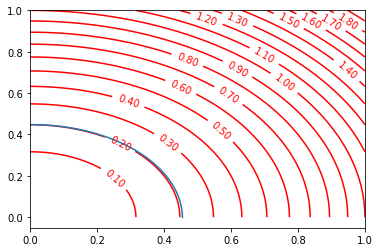

In [58]:
#résultat 1 

def g1(x,y) :
    return x**2+y**2

#On importe une fonction pré-intégrée à numpy qui va nous tracer les lignes de niveau exactes de la fonction :

x , y = np.meshgrid(np.linspace(0,1,101),np.linspace(0,1,101))
z1 = g1(x,y)
 
graphe = plt.contour(x,y,z1,20,colors='red')
plt.clabel(graphe,inline=1,fontsize=10,fmt='%3.2f')

X,Y = simple_contour_euler(g1,0.2)
plt.plot(X,Y)
plt.show()

Observations :

    Ce premier résultat est plutôt satisfaisant :nous obtenons bien une ligne de niveau ! Mais nous observons toutefois que la précision de la ligne de niveau mériterait d'être améliorée...

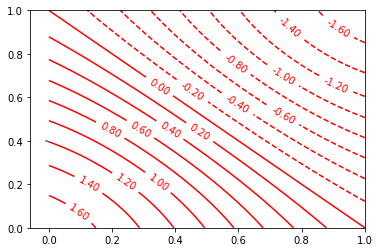

In [59]:
#résultat 2

def g2(x,y):
    return 2*(np.exp(-x**2-y**2)-np.exp(-(x-1)**2-(y-1)**2))

x , y = np.meshgrid(np.linspace(0,1,101),np.linspace(0,1,101))
z2 = g2(x,y)
 
graphe = plt.contour(x,y,z2,20,colors='red')
plt.clabel(graphe,inline=1,fontsize=10,fmt='%3.2f')

X,Y = simple_contour_euler(g2,1.2)
plt.plot(X,Y)
plt.show()


Observations :

    Au delà du problème de précision précédemment observé, ici nous faisons face à un problème d'enjeu supérieur : aucune ligne de niveau ne s'affiche, mise à part une tentative de tracé observable à gauche en bleu. 
    

Nous avons donc deux objectifs pour la suite :

    - améliorer la précision dans le cas où le programme fonctionne
    - en cas d'impossibilité à trouver une ligne de niveau, inverser le sens selon lequel on cherche la ligne de niveau
    
    

Afin de répondre à ces deux nouvelles exigences, nous avons décidé d'apporter deux modifications à notre fonction : utiliser une méthode de type Runge-Kuta au lieu d'une méthode de type Euler pour augmenter la précision du tracé et tenter deux sens de tracé d'une ligne de niveau pour ne pas se retrouver avec l'erreur précédente.

La méthode Runge-Kuta d'ordre 2 est la suivante :
    - on part d'un point de la ligne de niveau, x_{n}
    - on se déplace d'une distance delta en suivant l'orthogonal du gradient en ce point pour arriver au point x_{n+1} (qui aurait été le point retenu par la méthode Euler)
    - on considère le point x_{n+2} qui correspond au point moyenné de x_{n} et x_{n+1}
    - on calcule l'orthogonal au gradient de la fonction en x_{n+2}, noté ici _grad_
    - on se déplace depuis x_{n} d'une distance delta en suivant _grad_, pour obtenir le point x_{n+3} qui appartient à la ligne de niveau considérée
    
De plus, on ajoute une condition qui en cas de sortie du domaine dès le premier tracé de point, lance une recherche de ligne de niveau dans le sens opposé.

In [53]:
#code
def simple_contour_rk2(f, c=0.0, delta=0.01):
    s=find_seed(f,c)
    if s==None:
        shadok=np.array([])
        return shadok,shadok
    X=[0]
    Y=[s]
    x0=0
    y0=s
    
    def grad_f(x,y) :
        g = autograd.grad
        return np.r_[g(f,0)(x,y),g(f,1)(x,y)]
        
    g=grad_f(float(x0),float(y0))
    x=g[0]
    y=g[1]
    lenght = np.sqrt(x**2+y**2)
    ortho=np.array([y,-x])/lenght * delta
    count=0
    
    while 0<= x0+ortho[0] <=1 and 0 <= y0+ortho[1] <=1:
        count+=1
        
        g=grad_f(float(x0),float(y0))
        x=g[0]
        y=g[1]
        lenght = np.sqrt(x**2+y**2)
        ortho=np.array([y,-x])/lenght * delta
    
        x1 = ortho[0]+x0
        y1 = ortho[1]+y0
        
        xbis=(x0+x1)/2
        ybis=(y0+y1)/2
        
        g=grad_f(float(xbis),float(ybis))
        x=g[0]
        y=g[1]
        lenght = np.sqrt(x**2+y**2)
        ortho=np.array([y,-x])/lenght * delta
        
        x0=ortho[0]+x0
        y0=ortho[1]+y0
        
        X.append(x0)
        Y.append(y0)
    
    if (not (0<= x0+ortho[0] <=1 and 0 <= y0+ortho[1] <=1)) and count==0:
        count+=1
        X,Y=simple_contour_rk2(f,c,-delta)
    return (np.array(X),np.array(Y))

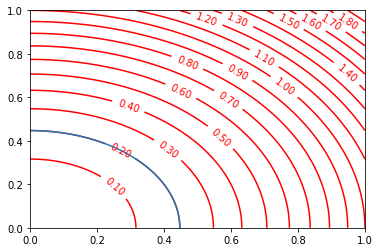

In [54]:
#résultat 1 

def g1(x,y) :
    return x**2+y**2

#On importe une fonction pré-intégrée à numpy qui va nous tracer les lignes de niveau exactes de la fonction :

x , y = np.meshgrid(np.linspace(0,1,101),np.linspace(0,1,101))
z1 = g1(x,y)
 
graphe = plt.contour(x,y,z1,20,colors='red')
plt.clabel(graphe,inline=1,fontsize=10,fmt='%3.2f')

X,Y = simple_contour_rk2(g1,0.2)
plt.plot(X,Y)
plt.show()

La précision atteinte en passant de la méthode Euler à la méthode Runge-Kuta d'ordre 2 est très satisfaisante.
Testons maintenant si le problème n°2 rencontré précédement a bien été corrigé :

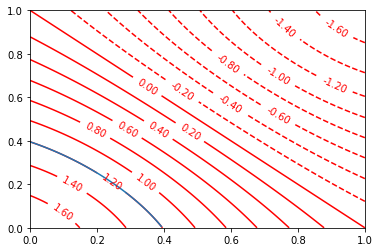

In [55]:
#résultat 2

def g2(x,y):
    return 2*(np.exp(-x**2-y**2)-np.exp(-(x-1)**2-(y-1)**2))

x , y = np.meshgrid(np.linspace(0,1,101),np.linspace(0,1,101))
z2 = g2(x,y)
 
graphe = plt.contour(x,y,z2,20,colors='red')
plt.clabel(graphe,inline=1,fontsize=10,fmt='%3.2f')

X,Y = simple_contour_rk2(g2,1.2)
plt.plot(X,Y)
plt.show()

In [ ]:
Le problème a bien été résolu ! De plus on observe encore une fois une bonne précision.

### Fonction contour complexe

In [56]:
#code contour complexe
LEFT, UP, RIGHT, DOWN = 0, 1, 2, 3  # clockwise


def rotate_direction(direction, n=1):
    return (direction + n) % 4


def rotate(x, y, n=1):
    if n == 0:
        return x, y
    elif n >= 1:
        return rotate(1 - y, x, n - 1)
    else:
        assert n < 0
        return rotate(x, y, n=-3 * n)


def rotate_function(f, n=1):
    def rotated_function(x, y):
        xr, yr = rotate(x, y, -n)
        return f(xr, yr)

    return rotated_function


# Complex Contouring
# ------------------------------------------------------------------------------

# Customize the simple_contour function used in contour :
# simple_contour = smart_simple_contour


def contour(f, c, xs=[0.0, 1.0], ys=[0.0, 1.0], delta=0.01):
    curves = []
    nx, ny = len(xs), len(ys)
    for i in range(nx - 1):
        for j in range(ny - 1):
            xmin, xmax = xs[i], xs[i + 1]
            ymin, ymax = ys[j], ys[j + 1]

            def f_cell(x, y):
                return f(xmin + (xmax - xmin) * x, ymin + (ymax - ymin) * y)

            done = set()
            for n in [0, 1, 2, 3]:
                if n not in done:
                    rotated_f_cell = rotate_function(f_cell, n)
                    x_curve_r, y_curve_r = simple_contour_rk2(rotated_f_cell, c, delta)
                    exit = None
                    if len(x_curve_r) >= 1:
                        xf, yf = x_curve_r[-1], y_curve_r[-1]
                        if xf == 0.0:
                            exit = LEFT
                        elif xf == 1.0:
                            exit = RIGHT
                        elif yf == 0.0:
                            exit = DOWN
                        elif yf == 1.0:
                            exit = UP
                    if exit is not None:  # a fully successful contour fragment
                        exit = rotate_direction(exit, n)
                        done.add(exit)

                    x_curve, y_curve = [], []
                    for x_r, y_r in zip(x_curve_r, y_curve_r):
                        x, y = rotate(x_r, y_r, n=-n)
                        x_curve.append(x)
                        y_curve.append(y)
                    x_curve = np.array(x_curve)
                    y_curve = np.array(y_curve)
                    curves.append(
                        (xmin + (xmax - xmin) * x_curve, ymin + (ymax - ymin) * y_curve)
                    )
    return curves

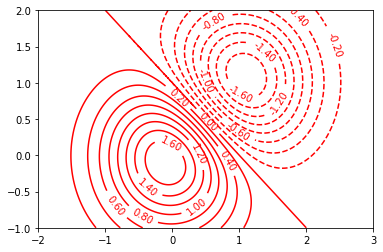

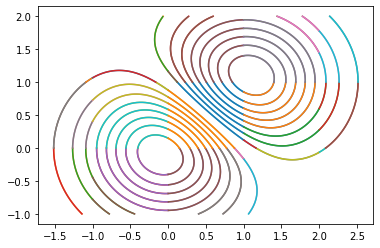

In [60]:
def h(x,y):
    return 2*(np.exp(-x**2-y**2)-np.exp(-(x-1)**2-(y-1)**2))

x , y = np.meshgrid(np.linspace(-2,3,501),np.linspace(-1,2,301))
z2 = h(x,y)
 
graphe = plt.contour(x,y,z2,20,colors='red')
plt.clabel(graphe,inline=1,fontsize=10,fmt='%3.2f')
plt.show()


for k in range(-8,9):
    if k!=0:
        stock = contour(h,k*0.2,[-2,-1,0,1,2,3],[-1,0,1,2])
        for x,y in stock:
            plt.plot(x,y)
    
plt.show()


Observations :

    ça marche ! La figure obtenue est satisfaisante. Maintenant, nous allons la superposer au résultat fourni par les fonctions intégrées à python.

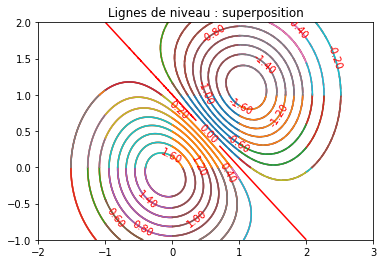

In [51]:
def h(x,y):
    return 2*(np.exp(-x**2-y**2)-np.exp(-(x-1)**2-(y-1)**2))

x , y = np.meshgrid(np.linspace(-2,3,501),np.linspace(-1,2,301))
z2 = h(x,y)
 
graphe = plt.contour(x,y,z2,20,colors='red')
plt.clabel(graphe,inline=1,fontsize=10,fmt='%3.2f')


for k in range(-8,9):
    if k != 0 :
        stock = contour(h,k*0.2,[-2,-1,0,1,2,3],[-1,0,1,2])
        for x,y in stock:
            plt.plot(x,y)
            
plt.title("Lignes de niveau : superposition")    
plt.show()


Observations :
    
    On obtient donc des résultats similaires que ce soit avec la fonction contour intégrée à numpy ou notre fonction. Une seule erreur demeure : nous n'arrivons pas à tracer la ligne de niveau associée à la valeur 0 et pensons qu'il s'agit d'une subtilité de contour complexe qui nous a échappé. 
    Nous demeurons toutefois satisfaits.
    
Allyriane Jousse Della Giustina & Elie Lesec